In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import json
import h5py

import windIO
import wind
import windWT as wt
import windCAD
import windOF as foam
import windCodes

import winsound

from matplotlib.ticker import FuncFormatter

## Basic definitions

In [3]:
les_dir = r"D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/"

dir_wtVl_tngE2 = r"D:/tempData_depot/simData_CandC/wt_tngE2/"
dir_wtVl_tngE3 = r"D:/tempData_depot/simData_CandC/wt_tngE3/"

runIDs = ['p1', 'p2', 'p3', 'p4', 'p5',]

dir_wtCp_tngE2 = [r"E:/TNG/rawHFPI/tngE2"+x+"/" for x in runIDs]
dir_wtCp_tngE3 = [r"E:/TNG/rawHFPI/tngE3"+x+"/" for x in runIDs]

saveFigs = False
figDir = les_dir+ r"__plots/"
if not os.path.exists(figDir):
    os.makedirs(figDir)

In [4]:
caseDict = {
    # 'AoAs':     [0.0, 10.0, 20.0, 30.0, 40.0, 45.0, 50.0, 60.0, 70.0, 80.0, 90.0],
    'AoAs':     [0.0, 10.0, 20.0, 40.0, 45.0, 50.0, 70.0, 80.0, 90.0],
    'profile':  {'dir':les_dir+'tngE2.ed.t3.r4a', 'probeName':'prof_x0_y0'},
    'p0_Z':     0.0, # [m] probe height
    0.0:        {'dir':les_dir+'tngE2.00d.m0.v0', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    10.0:       {'dir':les_dir+'tngE2.10d.m0.v0', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    20.0:       {'dir':les_dir+'tngE2.20d.m0.v0', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    # 30.0:       {'dir':les_dir+'tngE2.30d.m0.v0', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    40.0:       {'dir':les_dir+'tngE2.40d.m0.v0', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    45.0:       {'dir':les_dir+'tngE2.45d.m0.v0', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    50.0:       {'dir':les_dir+'tngE2.50d.m0.v0', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    # 60.0:       {'dir':les_dir+'tngE2.60d.m0.v0', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    70.0:       {'dir':les_dir+'tngE2.70d.m0.v0', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    80.0:       {'dir':les_dir+'tngE2.80d.m0.v0', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
    90.0:       {'dir':les_dir+'tngE2.90d.m0.v0', 'probeName':'probes_WTtaps', 'p0_probeName':'prof_x0_y0'},
}


In [5]:
B = 0.2744
D = 0.183
lScl=1/50.0

Hr = 0.08  # ridge height
roofSlope = np.rad2deg(np.arctan(0.25/12))  # roof slope
He = Hr - D/2.0*np.sin(np.deg2rad(roofSlope))  # eaves height
Havg = np.mean([Hr, He])
H = Havg  # average roof height
print("Hr = {:.5g} m, He = {:.5g} m, Havg = {:.5g} m".format(Hr, He, Havg))

areaFactor_toFSm2 = (1/lScl**2)   # convert mm2 to m2 and normalize by the square of the length scale

badTaps = None
# badTaps = [1316, 1807, 2609,]


Hr = 0.08 m, He = 0.078094 m, Havg = 0.079047 m


## Building Geometry

In [6]:
tapFile = r"D:/tempData_depot/simData_CandC/tngTapDefinition.csv"
tapInfo = pd.read_csv(tapFile)

faceID = [1,2,3,4,5,6]
name = ['Roof_1','Roof_2','Wall_1','Wall_2','Wall_3','Wall_4']
note = ['','','','','','']
origin = [[0,0,0.08],
          [0,-0.0915,0.07809375],
          [-0.1372,0,0],
          [0,-0.0915,0],
          [0.1372,0,0],
          [0,0.0915,0],]
basisVectors = [[[1,0,0],[0,0.999783057,0.020828814],[0,-0.020828814,0.999783057]],
                [[1,0,0],[0,0.999783057,-0.020828814],[0,0.020828814,0.999783057]],
                [[0,0,-1],[-1,0,0],[0,1,0]],
                [[1,0,0],[0,0,-1],[0,1,0]],
                [[0,0,1],[1,0,0],[0,1,0]],
                [[-1,0,0],[0,0,1],[0,1,0]],]

origin_plt = [[0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              [0, 0],
              ]

basisVectors_plt = [[[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    [[0, 1], [-1, 0]],
                    ]
vertices = [[[-0.091519855,-0.1372],[0,-0.1372],[0,0.1372],[-0.091519855,0.1372],[-0.091519855,-0.1372]],
            [[0,-0.1372],[0.091519855,-0.1372],[0.091519855,0.1372],[0,0.1372],[0,-0.1372]],
            [[-0.0915,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0,-0.1532],[-0.0915,-0.15510625],[-0.0915,-0.2332]],
            [[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,-0.1372]],
            [[-0.0915,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0,0.1532],[-0.0915,0.15510625],[-0.0915,0.2332]],
            [[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,-0.1372]],]



In [7]:
# Zone Dict definitions

zoneDict_NBCC = [
        {    # Face 1
            0:['NBCC 2020', 'Zone c', np.array([[-0.091519855,-0.1372],[-0.071519855,-0.1372],[-0.071519855,-0.1172],[-0.091519855,-0.1172],[-0.091519855,-0.1372]])],
            1:['NBCC 2020', 'Zone c', np.array([[-0.091519855,0.1172],[-0.071519855,0.1172],[-0.071519855,0.1372],[-0.091519855,0.1372],[-0.091519855,0.1172]])],
            2:['NBCC 2020', 'Zone s', np.array([[-0.071519855,-0.1372],[0,-0.1372],[0,-0.1172],[-0.071519855,-0.1172],[-0.071519855,-0.1372]])],
            3:['NBCC 2020', 'Zone s', np.array([[-0.091519855,-0.1172],[-0.071519855,-0.1172],[-0.071519855,0.1172],[-0.091519855,0.1172],[-0.091519855,-0.1172]])],
            4:['NBCC 2020', 'Zone s', np.array([[-0.071519855,0.1172],[0,0.1172],[0,0.1372],[-0.071519855,0.1372],[-0.071519855,0.1172]])],
            5:['NBCC 2020', 'Zone r', np.array([[-0.071519855,-0.1172],[0,-0.1172],[0,0.1172],[-0.071519855,0.1172],[-0.071519855,-0.1172]])],
        },
        {   # Face 2
            0:['NBCC 2020', 'Zone c', np.array([[0.091519855,-0.1372],[0.071519855,-0.1372],[0.071519855,-0.1172],[0.091519855,-0.1172],[0.091519855,-0.1372]])],
            1:['NBCC 2020', 'Zone c', np.array([[0.091519855,0.1172],[0.071519855,0.1172],[0.071519855,0.1372],[0.091519855,0.1372],[0.091519855,0.1172]])],
            2:['NBCC 2020', 'Zone s', np.array([[0.071519855,-0.1372],[0,-0.1372],[0,-0.1172],[0.071519855,-0.1172],[0.071519855,-0.1372]])],
            3:['NBCC 2020', 'Zone s', np.array([[0.091519855,-0.1172],[0.071519855,-0.1172],[0.071519855,0.1172],[0.091519855,0.1172],[0.091519855,-0.1172]])],
            4:['NBCC 2020', 'Zone s', np.array([[0.071519855,0.1172],[0,0.1172],[0,0.1372],[0.071519855,0.1372],[0.071519855,0.1172]])],
            5:['NBCC 2020', 'Zone r', np.array([[0.071519855,-0.1172],[0,-0.1172],[0,0.1172],[0.071519855,0.1172],[0.071519855,-0.1172]])],
        },
        {   # Face 3
            0:['NBCC 2020', 'Zone e', np.array([[-0.0915,-0.2332],[-0.0715,-0.2332],[-0.0715,-0.154689583],[-0.0915,-0.15510625],[-0.0915,-0.2332]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.0715,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0.0715,-0.154689583],[0.0715,-0.2332]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.0715,-0.2332],[0.0715,-0.2332],[0.0715,-0.154689583],[0,-0.1532],[-0.0715,-0.154689583],[-0.0715,-0.2332]])],
        },
        {   # Face 4
            0:['NBCC 2020', 'Zone e', np.array([[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,-0.1172],[0.107519855,-0.1172],[0.107519855,-0.1372]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.107519855,0.1172],[0.185613605,0.1172],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,0.1172]])],
            2:['NBCC 2020', 'Zone w', np.array([[0.107519855,-0.1172],[0.185613605,-0.1172],[0.185613605,0.1172],[0.107519855,0.1172],[0.107519855,-0.1172]])],
        },
        {   # Face 5
            0:['NBCC 2020', 'Zone e', np.array([[-0.0915,0.2332],[-0.0715,0.2332],[-0.0715,0.154689583],[-0.0915,0.15510625],[-0.0915,0.2332]])],
            1:['NBCC 2020', 'Zone e', np.array([[0.0715,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0.0715,0.154689583],[0.0715,0.2332]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.0715,0.2332],[0.0715,0.2332],[0.0715,0.154689583],[0,0.1532],[-0.0715,0.154689583],[-0.0715,0.2332]])],
        },
        {   # Face 6
            0:['NBCC 2020', 'Zone e', np.array([[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,-0.1172],[-0.107519855,-0.1172],[-0.107519855,-0.1372]])],
            1:['NBCC 2020', 'Zone e', np.array([[-0.107519855,0.1172],[-0.185613605,0.1172],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,0.1172]])],
            2:['NBCC 2020', 'Zone w', np.array([[-0.107519855,-0.1172],[-0.185613605,-0.1172],[-0.185613605,0.1172],[-0.107519855,0.1172],[-0.107519855,-0.1172]])],
        },
]

zoneDict_ASCE = [
        {    # Face 1
            0:['ASCE 7-22', 'Zone 3', np.array([[-0.0435, 0.1372], [-0.0915, 0.1372], [-0.0915, 0.0892], [-0.0755, 0.0892], [-0.0755, 0.1212], [-0.0435, 0.1212], [-0.0435, 0.1372], ])],
            1:['ASCE 7-22', 'Zone 3', np.array([[-0.0915, -0.0892], [-0.0915, -0.1372], [-0.0435, -0.1372], [-0.0435, -0.1212], [-0.0755, -0.1212], [-0.0755, -0.0892], [-0.0915, -0.0892], ])],
            2:['ASCE 7-22', 'Zone 2', np.array([[0, 0.1372], [-0.0435, 0.1372], [-0.0435, 0.1212], [-0.0755, 0.1212], [-0.0755, 0.0892], [-0.0915, 0.0892], [-0.0915, -0.0892], 
                                                [-0.0755, -0.0892], [-0.0755, -0.1212], [-0.0435, -0.1212], [-0.0435, -0.1372], [0, -0.1372], [0, -0.0892], [-0.0435, -0.0892], 
                                                [-0.0435, 0.0892], [0, 0.0892], [0, 0.1372], ])],
            3:['ASCE 7-22', 'Zone 1', np.array([[0, 0.0892], [-0.0435, 0.0892], [-0.0435, -0.0892], [0, -0.0892], [0, 0.0892], ])],
        },
        {   # Face 2
            0:['ASCE 7-22', 'Zone 3', np.array([[0.0435, 0.1372], [0.0915, 0.1372], [0.0915, 0.0892], [0.0755, 0.0892], [0.0755, 0.1212], [0.0435, 0.1212], [0.0435, 0.1372], ])],
            1:['ASCE 7-22', 'Zone 3', np.array([[0.0915, -0.0892], [0.0915, -0.1372], [0.0435, -0.1372], [0.0435, -0.1212], [0.0755, -0.1212], [0.0755, -0.0892], [0.0915, -0.0892], ])],
            2:['ASCE 7-22', 'Zone 2', np.array([[0, 0.1372], [0.0435, 0.1372], [0.0435, 0.1212], [0.0755, 0.1212], [0.0755, 0.0892], [0.0915, 0.0892], [0.0915, -0.0892], 
                                                [0.0755, -0.0892], [0.0755, -0.1212], [0.0435, -0.1212], [0.0435, -0.1372], [0, -0.1372], [0, -0.0892], [0.0435, -0.0892], 
                                                [0.0435, 0.0892], [0, 0.0892], [0, 0.1372], ])],
            3:['ASCE 7-22', 'Zone 1', np.array([[0, 0.0892], [0.0435, 0.0892], [0.0435, -0.0892], [0, -0.0892], [0, 0.0892], ])],
        },
        {   # Face 3
            0:['ASCE 7-22', 'Zone 4', np.array([[-0.0715,-0.2332],[0.0715,-0.2332],[0.0715,-0.154689583],[0,-0.1532],[-0.0715,-0.154689583],[-0.0715,-0.2332]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[-0.0915,-0.2332],[-0.0715,-0.2332],[-0.0715,-0.154689583],[-0.0915,-0.15510625],[-0.0915,-0.2332]])],
            2:['ASCE 7-22', 'Zone 5', np.array([[0.0715,-0.2332],[0.0915,-0.2332],[0.0915,-0.15510625],[0.0715,-0.154689583],[0.0715,-0.2332]])],
        },
        {   # Face 4
            0:['ASCE 7-22', 'Zone 5', np.array([[0.107519855,-0.1372],[0.185613605,-0.1372],[0.185613605,-0.1172],[0.107519855,-0.1172],[0.107519855,-0.1372]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[0.107519855,0.1172],[0.185613605,0.1172],[0.185613605,0.1372],[0.107519855,0.1372],[0.107519855,0.1172]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[0.107519855,-0.1172],[0.185613605,-0.1172],[0.185613605,0.1172],[0.107519855,0.1172],[0.107519855,-0.1172]])],
        },
        {   # Face 5
            0:['ASCE 7-22', 'Zone 5', np.array([[-0.0915,0.2332],[-0.0715,0.2332],[-0.0715,0.154689583],[-0.0915,0.15510625],[-0.0915,0.2332]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[0.0715,0.2332],[0.0915,0.2332],[0.0915,0.15510625],[0.0715,0.154689583],[0.0715,0.2332]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[-0.0715,0.2332],[0.0715,0.2332],[0.0715,0.154689583],[0,0.1532],[-0.0715,0.154689583],[-0.0715,0.2332]])],
        },
        {   # Face 6
            0:['ASCE 7-22', 'Zone 5', np.array([[-0.107519855,-0.1372],[-0.185613605,-0.1372],[-0.185613605,-0.1172],[-0.107519855,-0.1172],[-0.107519855,-0.1372]])],
            1:['ASCE 7-22', 'Zone 5', np.array([[-0.107519855,0.1172],[-0.185613605,0.1172],[-0.185613605,0.1372],[-0.107519855,0.1372],[-0.107519855,0.1172]])],
            2:['ASCE 7-22', 'Zone 4', np.array([[-0.107519855,-0.1172],[-0.185613605,-0.1172],[-0.185613605,0.1172],[-0.107519855,0.1172],[-0.107519855,-0.1172]])],
        },
]

# file = caseDir+'NBCC_zoneDict.json'
# with open(file, 'w') as f:
#     json.dump(zoneDict,f, indent=4, separators=(',', ':'))

In [8]:
# nominalPanelAreas=[1.0e-4, 2.45e-4, 4.8e-4, 7.1e-4, 1e-3], #[5e-5, 8e-5, 1.5e-4, 5e-4]
# nominalPanelAreas=[4.4e-5, 8.15e-5, 1.3e-4, 5e-4, 6.8e-4, 1.3e-3,]  # Final! All are tested. 1.3e-3 results in blunt edge zones in the walls but no error.
nominalPanelAreas=[4.4e-5, 8.15e-5, 1.3e-4, 5.25e-4, 6.8e-4, 1.3e-3,]  # 5e-4 causes problems in ASCE 7-22 zone 2 
# nominalPanelAreas=[1.3e-3,]
# nominalPanelAreas=[4.8e-4, 7.2e-4, 1e-3]

faces_NBCC = []
for i,f in enumerate(faceID):
    idx = tapInfo.index[tapInfo.faceID == f]
    tapCoords = np.transpose(np.array([tapInfo.x[idx], tapInfo.y[idx]]))
    tapNos = np.array(tapInfo.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                zoneDict=zoneDict_NBCC[i],
                nominalPanelAreas=nominalPanelAreas,
                numOfNominalPanelAreas=3,
                badTaps=badTaps,
                allBldgTaps=np.array(tapInfo.tapNo,dtype=int),
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces_NBCC.append(fc)

faces_ASCE = []
for i,f in enumerate(faceID):
    idx = tapInfo.index[tapInfo.faceID == f]
    tapCoords = np.transpose(np.array([tapInfo.x[idx], tapInfo.y[idx]]))
    tapNos = np.array(tapInfo.tapNo[idx],dtype=int)
    idxOrig = idx

    fc = windCAD.face(
                name=name[i],
                ID=f,
                origin=origin[i],
                basisVectors=basisVectors[i],
                origin_plt=origin_plt[i],
                basisVectors_plt=basisVectors_plt[i],
                vertices=vertices[i],
                tapNo=tapNos,
                tapIdx=idxOrig,
                tapName=None,
                tapCoord=tapCoords,
                zoneDict=zoneDict_ASCE[i],
                nominalPanelAreas=nominalPanelAreas,
                numOfNominalPanelAreas=3,
                badTaps=badTaps,
                allBldgTaps=np.array(tapInfo.tapNo,dtype=int),
                )
    # fc.plot(figSize=[20,15], overlayPanels=True, overlayTaps=True, overlayTribs=True, overlayZones=True)
    faces_ASCE.append(fc)
# file = caseDir+'ttu_bldgGeom.json'
# allFaces.writeToFile(file_basic=file)

Generating panels ...


c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
     

c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_polygons
  return lib.voronoi_polygons(geometry, tolerance, extend_to, only_edges, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\shapely\constructive.py:963: RuntimeWarning: invalid value encountered in voronoi_pol

Done generating panels ...
Error summary in paneling:
{
    "NBCC 2020 -- Zone c": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone s": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
            "A=8.15e-05": [],
            "A=0.00013": [],
            "A=0.000525": [],
            "A=0.00068": [],
            "A=0.0013": []
        }
    },
    "NBCC 2020 -- Zone r": {
        "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]": [],
        "tap idxs with weight errors": {
            "A=4.4e-05": [],
     

In [9]:
bldg = wind.bldgCp(bldgName='TTU_1to50_TNG',
                faces=faces_ASCE,
                H=H,D=D,B=B,roofSlope=1.2,lScl=lScl,
                caseName='GeomDefinition',
                AoA_zero_deg_basisVector=[1,0],
                AoA_rotation_direction='CCW',
                badTaps=badTaps,
                )
print(json.dumps(bldg.panelingErrors, indent=4, separators=(',', ':')))

Refreshing GeomDefinition...
Verifying data ...
Done refreshing GeomDefinition.

{
    "Face 1":{
        "ASCE 7-22 -- Zone 3":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]":[],
            "tap idxs with weight errors":{
                "A=4.4e-05":[],
                "A=8.15e-05":[],
                "A=0.00013":[],
                "A=0.000525":[],
                "A=0.00068":[],
                "A=0.0013":[]
            }
        },
        "ASCE 7-22 -- Zone 2":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05, 0.00013, 0.000525, 0.00068, 0.0013]":[],
            "tap idxs with weight errors":{
                "A=4.4e-05":[],
                "A=8.15e-05":[],
                "A=0.00013":[],
                "A=0.000525":[],
                "A=0.00068":[],
                "A=0.0013":[]
            }
        },
        "ASCE 7-22 -- Zone 1":{
            "nom. areas idxs with tiling errors [4.4e-05, 8.15e-05

### Plots

(-0.25651999999999997,
 0.25651999999999997,
 -0.20417496549999997,
 0.20417496549999997)

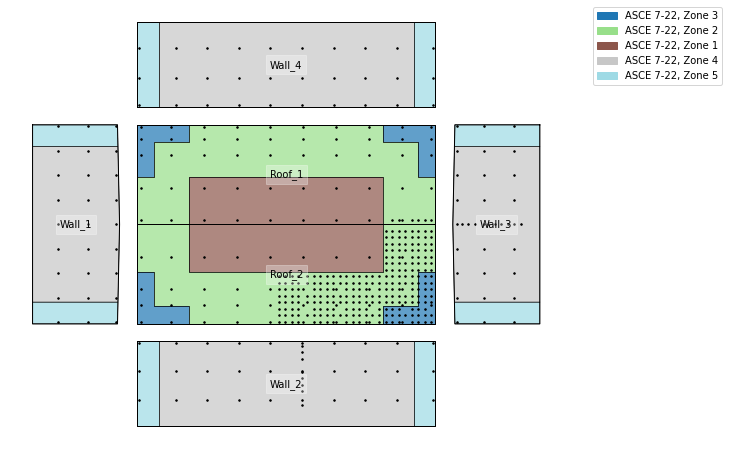

In [10]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot()

bldg.plotEdges(ax=ax,showName=True)
bldg.plotZones(ax=ax)
bldg.plotTaps(ax=ax)
# bldg.plotTribs(ax=ax)
# bldg.plotPanels(ax=ax,aIdx=2)

ax.axis('equal')
ax.axis('off')
# if saveFigs:
#     fig.savefig(figDir+"tapLayout.svg",format='svg',dpi=1200, bbox_inches='tight')



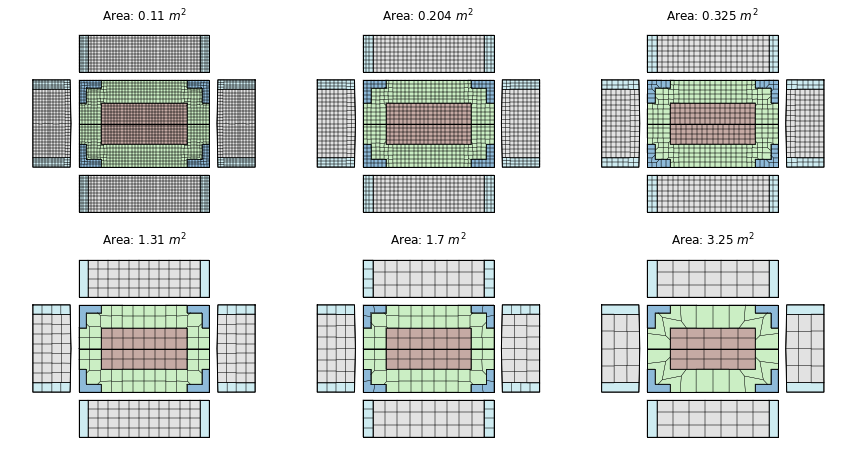

In [11]:

fig, axs = bldg.plotPanels_AllAreas(figsize=[12,6.4], nCols=3,
    areaUnit=r'$m^2$', areaFactor=areaFactor_toFSm2, areaFmt='{:2.3g}',
    )
# if saveFigs:
#     fig.savefig(figDir+"nominalPanelAreas_ASCE.svg",format='svg',dpi=1200, bbox_inches='tight')

## Wind field

### Read data

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:692: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:2773: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


0.00016113281448388675


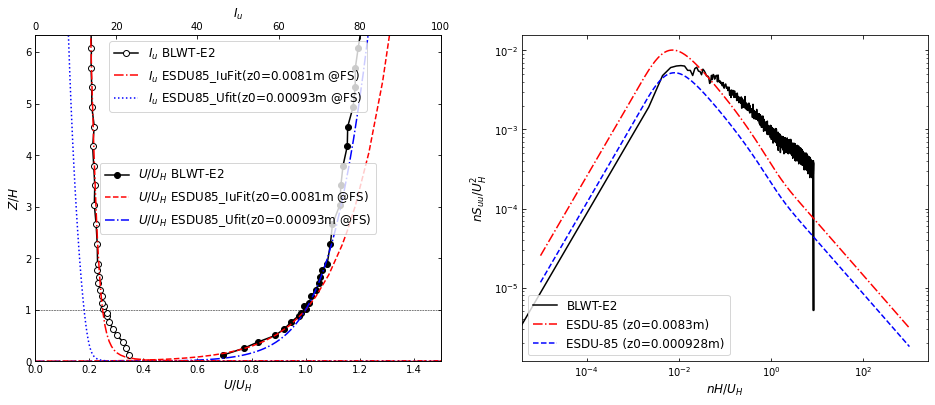

In [12]:
keepTH = True

temp = h5py.File(dir_wtVl_tngE2+"tngE2Fr1_forPython.mat", 'r')
wtVel_E2 = wind.profile(name="BLWT-E2", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, 
                        workSect_zLim=[0, 0.5], lScl=lScl,
                        keepTH=keepTH)
wtVel_E2.kwargs_z0_fit = {'fitTo':'Iu', # 'Iu' or 'U'
                        'uStar_init':1.0, 
                        'z0_init':0.001, 
                        'kwargs_z0Fit':{'z0i':[1e-10,1.0]}}
wtVel_E2.fit_z0(debugMode=True, )
print(wtVel_E2.z0_Iu)



# temp = h5py.File(dir_wtVl_tngE3+"tngE3Fr1_forPython.mat", 'r')
# wtVel_E3 = wind.profile(name="BLWT-E3", Z=temp['Z'][0][()],UofT=temp['UofT'][()],VofT=temp['VofT'][()],WofT=temp['WofT'][()],H=H,dt=temp['dt'][0][0],nSpectAvg=64, keepTH=keepTH)


### LES wind field

Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.ed.t3.r4a
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.ed.t3.r4a/postProcessing/prof_x0_y0
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Processing profile data.
  >> Reading pressure data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:692: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:2773: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


0.00048583984570141597

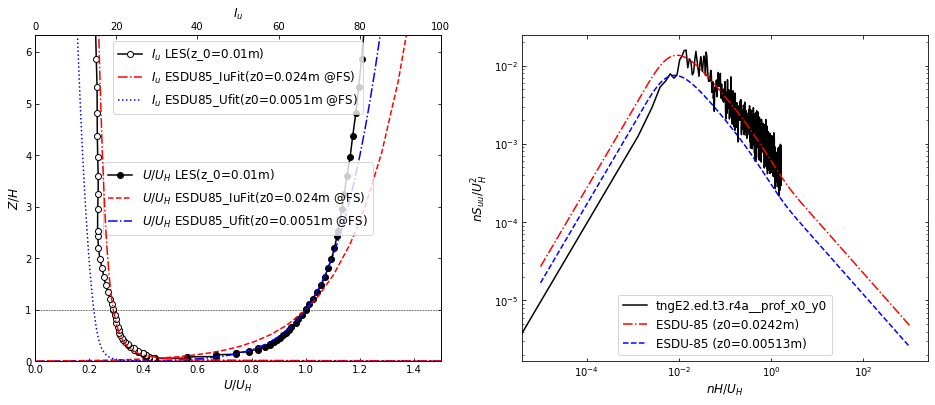

In [13]:

lesVel_E2 = foam.readVelProfile(caseDir=caseDict['profile']['dir'], probeName=caseDict['profile']['probeName'],H=H, readFromNPY_file=True, writeToFile=True,
                                kwargs_profile={'workSect_zLim':[0, 0.5],  'lScl':lScl,})
lesVel_E2.name = "LES(z_0=0.01m)"

lesVel_E2.kwargs_z0_fit_Iu = {'fitTo':'Iu', # 'Iu' or 'U'
                            'uStar_init':1.0, 
                            'z0_init':0.001, 
                            'kwargs_z0Fit':{'z0i':[1e-10,1.0]}}
lesVel_E2.fit_z0(debugMode=True, )

# lesVel_E3 = foam.processVelProfile(caseDir=dir_lesE3_00, probeName='probes.V1',H=H, trimTimeSegs=[[0,1.0]])
# lesVel_E3.name = "LES(z_0=0.087m)"

In [14]:
vel = wind.Profiles([wtVel_E2, lesVel_E2,])
esdu74_E2 = wind.ESDU74(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))
esdu85_E2 = wind.ESDU85(z0=0.01, Zref=H/lScl, Uref=25.0, Z=np.logspace(-1,2,100))


### Plot wind field

(<Figure size 864x864 with 9 Axes>,
 array([[<AxesSubplot:xlabel='$U/U_h$', ylabel='$Z/H$'>,
         <AxesSubplot:xlabel="$\\overline{u'w'}/U_h^2$", ylabel='$Z/H$'>,
         <AxesSubplot:>],
        [<AxesSubplot:xlabel='$I_u$', ylabel='$Z/H$'>,
         <AxesSubplot:xlabel='$I_v$', ylabel='$Z/H$'>,
         <AxesSubplot:xlabel='$I_w$', ylabel='$Z/H$'>],
        [<AxesSubplot:xlabel='$^xL_u/H$', ylabel='$Z/H$'>,
         <AxesSubplot:xlabel='$^xL_v/H$', ylabel='$Z/H$'>,
         <AxesSubplot:xlabel='$^xL_w/H$', ylabel='$Z/H$'>]], dtype=object))

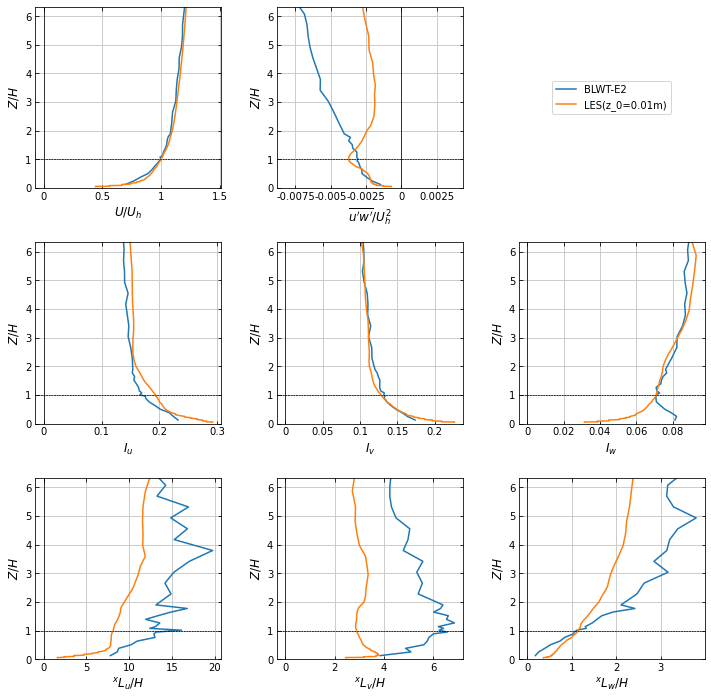

In [15]:
vel.plotProfile_basic2()


## Surface pressure, $C_p$

#### Wind tunnel data

In [16]:
analogChannels_idxs={
                'main_pitot': 0,
                'xref_pitot': 2,
            }
pressureExtraChannels_tapNos={
                'main_pitot_zero': 3009,
                'main_pitot_q': 3010,
                '20inch_pitot_zero': 3007,
                '20inch_pitot_q': 3008,
                'Uh_pitot_zero': 3005,
                'Uh_pitot_q': 3006,
            }

peakSpecs = wind.DEFAULT_PEAK_SPECS
peakSpecs['Num_seg'] = 16
peakSpecs['Duration'] = 16
peakSpecs['prob_non_excd'] = 0.8

mainRefPitotChnlIdx = 2
Zpitot = 1.48
Ntaps = 456
lowpassFreq=200.0
tMax_WT = 21.0 # equivalent to 30.0 LES data
tMax_Idx = int(tMax_WT*lowpassFreq)

tMax_Idx_vel = int(tMax_WT*wtVel_E2.samplingFreq)
wtVel_E2.UofT = wtVel_E2.UofT[:,:tMax_Idx_vel]
wtVel_E2.VofT = wtVel_E2.VofT[:,:tMax_Idx_vel]
wtVel_E2.WofT = wtVel_E2.WofT[:,:tMax_Idx_vel]
wtVel_E2.t = wtVel_E2.t[:tMax_Idx_vel]
wtVel_E2.Refresh()

# tMax_Idx_vel = int(tMax_WT*wtVel_E3.samplingFreq)

print(np.shape(wtVel_E2.t))

(33600,)


In [17]:
# cps_OP = []
i, rID = 0, runIDs[0]
# for i, rID in enumerate(runIDs):
print(">> Processing: OP-"+rID)
cp_raw = wt.BLWTL_HFPI(
    caseDir=dir_wtCp_tngE2[i],
    userNotes=None,
    Z_MainPitot=Zpitot,
    analogChannels_idxs=analogChannels_idxs,
    pressureExtraChannels_tapNos=pressureExtraChannels_tapNos,
    lowpassFreq=lowpassFreq,
    Ntaps=Ntaps,
    AoAsToRead=caseDict['AoAs'],
)
winsound.Beep(1000, 1000)
print("      Loaded raw data")
print(cp_raw.description)


>> Processing: OP-p1
Reading HFPI data from: E:/TNG/rawHFPI/tngE2p1/
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P001a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P002a.pssd
       AoA 5.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 40.0, 45.0, 50.0, 70.0, 80.0, 90.0]. Skipping.
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P003a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P004a.pssd
       AoA 15.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 40.0, 45.0, 50.0, 70.0, 80.0, 90.0]. Skipping.
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P005a.pssd
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P006a.pssd
       AoA 25.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 40.0, 45.0, 50.0, 70.0, 80.0, 90.0]. Skipping.
   Reading file: E:/TNG/rawHFPI/tngE2p1/TNGp1E02R001P007a.pssd
       AoA 30.0 is not in the list of AoAs to read: [0.0, 10.0, 20.0, 40.0, 45.0, 50.0, 70.0, 80.0, 90.0]. Skipping.
   Reading file: E:/TNG

(9, 456, 59976)
Re-scaling profile to match Uref ...
    Uref_avg = 12.822 m/s
    U_ref_prof = 7.753 m/s
    U_ratio = 1.654
    time_ratio = 0.605
Refreshing OP_ASCE_C&C_p1...
Verifying data ...
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area-averaging for face Wall_4 ...
Done refreshing OP_ASCE_C&C_p1.

Shape of CpTH: (9, 456, 4200)
      << Complete!


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:692: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:2773: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


0.00010742187698925784

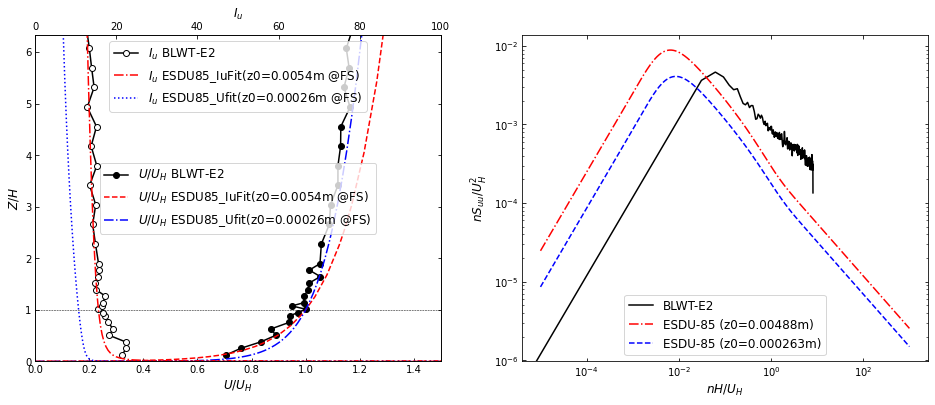

In [18]:

print(cp_raw.CpTH.shape)

WT_cp = wind.bldgCp(
                bldgName=bldg.name,
                faces=bldg.faces,
                H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                AoA_rotation_direction=bldg.AoA_rotation_direction,
                caseName='OP_ASCE_C&C_'+rID,
                refProfile=wtVel_E2,
                Zref_input=cp_raw.Z_MainPitot,
                Uref_input=cp_raw.Uref,
                Uref_FS=25.0,
                samplingFreq=cp_raw.sampleRate,
                AoA=cp_raw.AoA,
                CpOfT=cp_raw.CpTH[:,:,:tMax_Idx],
                notes_Cp=cp_raw.description,
                badTaps=None,
                reReferenceCpToH=True,
                pOfT=None,
                p0ofT=None,
                CpStats=None,
                peakSpecs=peakSpecs,
                CpStats_fields=['mean','std','peak','skewness','kurtosis'],
                keepTH=True,
                )
print(f"Shape of CpTH: {WT_cp.CpOfT.shape}")
winsound.Beep(1500, 1000)
print("      << Complete!")

WT_cp.profile.fit_z0(debugMode=True,)
# cps_OP.append(cp)

# del cp_raw, cp

In [19]:
print(WT_cp.profile.T_star)

3423.973451717946


## Load CFD Cp

In [20]:
allPres = []
nmin = 1000000000000
tCutIdx = 5000
readFromNPY_file=True
AoA_final = []
p0_profs = []
for i, aoa in enumerate(caseDict['AoAs']):
    p,probes,time = foam.readSurfacePressure(caseDir=caseDict[aoa]['dir'], probeName=caseDict[aoa]['probeName'], readFromNPY_file=readFromNPY_file, writeToFile=True)
    p0,probes_0,time_0  = foam.readSurfacePressure(caseDir=caseDict[aoa]['dir'], probeName=caseDict[aoa]['p0_probeName'], readFromNPY_file=readFromNPY_file, writeToFile=True)

    if p.shape[1] >= tCutIdx:
        # get the indices of common time steps between p0 and p. Don't apply tCutIdx here
        idx_p0 = np.where(np.isin(time_0, time))[0]
        idx_p = np.where(np.isin(time, time_0))[0]
        print(f"Shape of p0: {p0.shape}")
        print(f"Shape of p: {p.shape}")

        p = p[:, idx_p]
        p0 = p0[:, idx_p0]

        allPres.append(p - p0[-10, :])
        AoA_final.append(aoa)
        print(p.shape)
        nmin = min(nmin, p.shape[1])
        # p0_profs.append(p0_prof)

for i in range(len(allPres)):
    allPres[i] = allPres[i][:, :nmin]

allPressure = np.array(allPres)

print(allPressure.shape)

Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.00d.m0.v0
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.00d.m0.v0/postProcessing/probes_WTtaps
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.00d.m0.v0
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.00d.m0.v0/postProcessing/prof_x0_y0
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.
Shape of p0: (25, 24738)
Shape of p: (456, 24731)
(456, 24731)
Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.10d.m0.v0
Probe read from:		D:/tempData_depot/simData_CandC/wt_tngE2_final/main_r0/tngE2.10d.m0.v0/postProcessing/probes_WTtaps
  >> Reading probe data ...
  >> Reading data from NPY file.


#### LES data

In [21]:
# print(np.shape(p0_profs[0].pOfT))
# WT_cp.profile.kwargs_z0_fit = wtVel_E2.kwargs_z0_fit
# WT_cp.profile.fit_z0(debugMode=True)
print(bldg.AoA_zero_deg_basisVector)

[1, 0]


In [22]:
# casename = 'tngE2.00d.m0.v0'
# pres, pts, time_p, = foam.readSurfacePressure(caseDir=les_dir+casename, probeName='probes_WTtaps', )
# pres = np.expand_dims(pres.T, axis=0)
# print(pres.shape)
dt = np.diff(time).mean()
# add one dimension as a first dimension of pres


LES_Cp = wind.bldgCp(
                    bldgName=bldg.name,
                    faces=bldg.faces,
                    H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                    AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                    AoA_rotation_direction=bldg.AoA_rotation_direction,
                    caseName='LES',
                    refProfile=lesVel_E2,
                    samplingFreq=1/dt,
                    Uref_input=lesVel_E2.Uh,
                    Uref_FS=25.0,
                    AoA=AoA_final, #caseDict['AoAs'],
                    CpOfT=None,
                    notes_Cp='---',
                    badTaps=None,
                    reReferenceCpToH=False,
                    pOfT=allPressure,
                    # p0ofT=p0_prof.pOfT[:nmin,-10],
                    CpStats=None,
                    peakSpecs=peakSpecs,
                    CpStats_fields=['mean','std','peak','skewness','kurtosis'],
                    keepTH=True,
                    )

Refreshing LES...
Verifying data ...
Computing Cp time history ...
Uref = [11.99057731 11.99057731 11.99057731 11.99057731 11.99057731 11.99057731
 11.99057731]
Shape of self.pOfT = (7, 456, 5034)
Shape of p0ofT = ()
Shape of pOfT = (7, 456, 5034)
Shape of self.fluidDensity = ()
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area-averaging for face Wall_4 ...
Done refreshing LES.



# Old LES ###

In [23]:
dir_lesE2_00 = r"D:/tempData_depot/simData_CandC/__forICWE/ttuE010_000.0/"
dir_lesE2_45 = r"D:/tempData_depot/simData_CandC/__forICWE/ttuE010_450.2/"
dir_lesE2_90 = r"D:/tempData_depot/simData_CandC/__forICWE/ttuE010_900.1/"
dir_lesE3_00 = r"D:/tempData_depot/simData_CandC/__forICWE/ttuE087_000.0/"
dir_lesE3_45 = r"D:/tempData_depot/simData_CandC/__forICWE/ttuE087_450.2/"
dir_lesE3_90 = r"D:/tempData_depot/simData_CandC/__forICWE/ttuE087_900.0/"

figDir = r"D:/tempData_depot/simData_CandC/__forICWE/figs/"
if not os.path.exists(figDir):
    os.makedirs(figDir)

Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/__forICWE/ttuE010_000.0/
Probe read from:		D:/tempData_depot/simData_CandC/__forICWE/ttuE010_000.0//postProcessing/probes.V1
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Processing profile data.
  >> Reading pressure data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:692: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:2773: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


Processing OpenFOAM case:	D:/tempData_depot/simData_CandC/__forICWE/ttuE087_000.0/
Probe read from:		D:/tempData_depot/simData_CandC/__forICWE/ttuE087_000.0//postProcessing/probes.V1
  >> Reading probe data ...
  >> Reading data from NPY file.
             << Done!
  >> Processing profile data.
  >> Reading pressure data ...
  >> Reading data from NPY file.
             << Done!
  >> Finished reading probe data.


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:692: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:2773: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


0.0020802365234375004

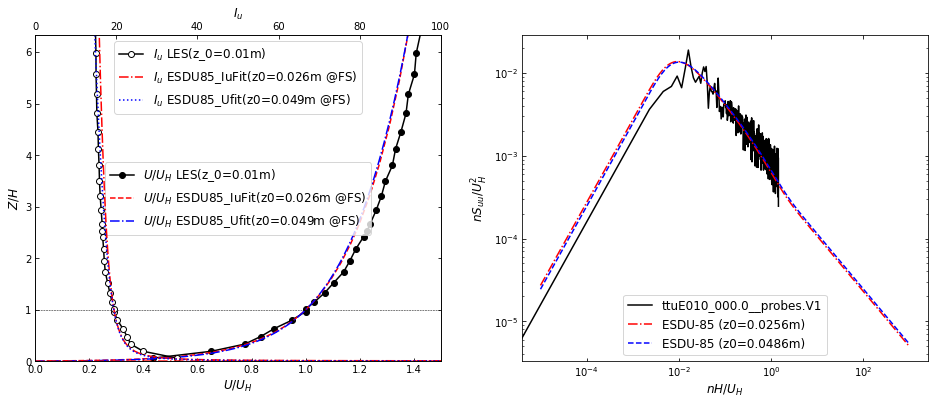

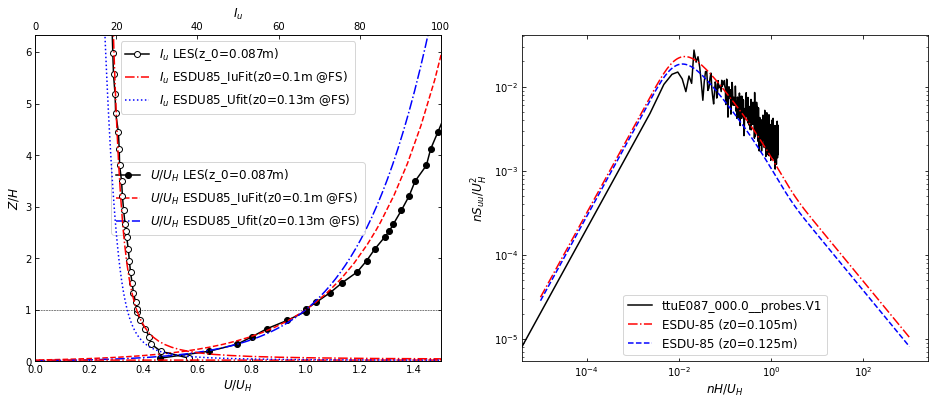

In [24]:
lesVel_E2_old = foam.readVelProfile(caseDir=dir_lesE2_00, probeName='probes.V1',H=H, trimTimeSegs=[[0,1.0]], writeToFile=True, readFromNPY_file=True,
                                       kwargs_profile={'workSect_zLim':[0, 0.5],  'lScl':lScl,})
lesVel_E2_old.name = "LES(z_0=0.01m)"
lesVel_E2_old.kwargs_z0_fit = {'fitTo':'Iu', # 'Iu' or 'U'
                        'uStar_init':1.0, 
                        'z0_init':0.01, 
                        'kwargs_z0Fit':{'z0i':[1e-5,0.3]}}
lesVel_E2_old.fit_z0(debugMode=True)


lesVel_E3_old = foam.readVelProfile(caseDir=dir_lesE3_00, probeName='probes.V1',H=H, trimTimeSegs=[[0,1.0]], writeToFile=True, readFromNPY_file=True,
                                       kwargs_profile={'workSect_zLim':[0, 0.5],  'lScl':lScl,})
lesVel_E3_old.name = "LES(z_0=0.087m)"
lesVel_E3_old.kwargs_z0_fit = {'fitTo':'Iu', # 'Iu' or 'U'
                        'uStar_init':1.0, 
                        'z0_init':0.01, 
                        'kwargs_z0Fit':{'z0i':[1e-5,0.5]}}
lesVel_E3_old.fit_z0(debugMode=True)

In [25]:
p0_ProbeName='probes.V0'
p0Idx = 30

trimTimeSegs=[[0,1.0]]
AoA = [0.0,45.0,90.0]

def getClosestIdx(Tp, Tp0, tol=0.004):
    idx = np.zeros_like(Tp,dtype=int)
    for i,tp in enumerate(Tp):
        idx[i] = np.argmin(np.abs(Tp0-tp))
        if abs(tp-Tp0[idx[i]]) > tol:
            print(f"Time gap b/n p and p0: {abs(tp-Tp0[idx[i]])}")

    return idx


           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_000.0/postProcessing/probes.V0/0/p
                55 probes with 475 time steps (0.0033 to 1.5675)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (475, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_000.0/postProcessing/probes.V0/1.56/p
                55 probes with 488 time steps (1.5633 to 3.1704)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (488, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_000.0/postProcessing/probes.V0/3.16/p
                55 probes with 557 time steps (3.1633 to 4.9981)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (557, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_000.0/postProcessing/probes.V0/4.98/p


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windOF.py:439: UserWarning: WARNING! Non-uniform time step detected in 'probes.V0'. The highest difference in time step is: 0.003900000000001569
  warnings.warn(msg)


           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_450.2/postProcessing/probes.V0/0/p
                55 probes with 116 time steps (0.0033 to 0.3828)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (116, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_450.2/postProcessing/probes.V0/0.38/p
                55 probes with 126 time steps (0.3833 to 0.7958)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (126, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_450.2/postProcessing/probes.V0/0.78/p
                55 probes with 136 time steps (0.7833 to 1.2288)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (136, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_450.2/postProcessing/probes.V0/1.22/p


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windOF.py:439: UserWarning: WARNING! Non-uniform time step detected in 'probes.V0'. The highest difference in time step is: 0.006299999999999528
  warnings.warn(msg)


           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_900.1/postProcessing/probes.V0/0/p
                55 probes with 139 time steps (0.0033 to 0.4587)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (139, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_900.1/postProcessing/probes.V0/0.44/p
                55 probes with 18 time steps (0.4433 to 0.4994)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (18, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_900.1/postProcessing/probes.V0/0.5/p
                55 probes with 241 time steps (0.5033 to 1.2953)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (241, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE010_900.1/postProcessing/probes.V0/1.28/p
   

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windOF.py:439: UserWarning: WARNING! Non-uniform time step detected in 'probes.V0'. The highest difference in time step is: 0.0055000000000005045
  warnings.warn(msg)


Refreshing LES-E2...
Verifying data ...
Computing Cp time history ...
Uref = [8.34803228 8.34803228 8.34803228]
Shape of self.pOfT = (3, 456, 9600)
Shape of p0ofT = ()
Shape of pOfT = (3, 456, 9600)
Shape of self.fluidDensity = ()
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area-averaging for face Wall_4 ...
Done refreshing LES-E2.



D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:692: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:2773: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


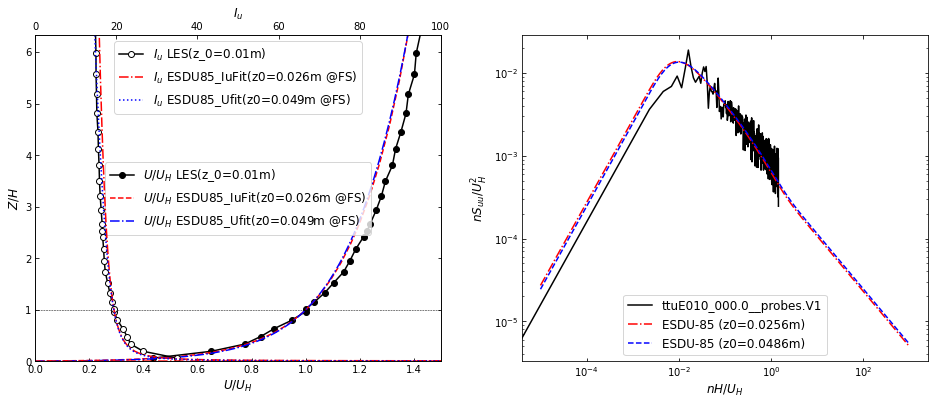

In [26]:

sIdx = 700
eIdx = 10300
nTime = eIdx-sIdx

# 0 deg
pOfTfile = dir_lesE2_00+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT = np.load(pOfTfile)
m,n = np.shape(pOfT)
pOfT = np.reshape(pOfT,(1,m,n))
T_p = np.load(dir_lesE2_00+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT = foam.read_OF_probe(probeName=p0_ProbeName, postProcDir=dir_lesE2_00+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT = np.reshape(np.transpose(p0OfT)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT = p0OfT[:,:,idx_p0]

pOfT = np.subtract(pOfT,p0OfT)[:,:,sIdx:eIdx]


# 45 deg
pOfTfile = dir_lesE2_45+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT_ = np.load(pOfTfile)
m,n = np.shape(pOfT_)
pOfT_ = np.reshape(pOfT_,(1,m,n))
T_p = np.load(dir_lesE2_45+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT_ = foam.read_OF_probe(probeName=p0_ProbeName, postProcDir=dir_lesE2_45+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT_ = np.reshape(np.transpose(p0OfT_)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT_ = p0OfT_[:,:,idx_p0]

pOfT_ = np.subtract(pOfT_,p0OfT_)
pOfT = np.concatenate((pOfT, pOfT_[:,:,sIdx:eIdx]), axis=0)


# 90 deg
pOfTfile = dir_lesE2_90+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT_ = np.load(pOfTfile)
m,n = np.shape(pOfT_)
pOfT_ = np.reshape(pOfT_,(1,m,n))
T_p = np.load(dir_lesE2_90+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT_ = foam.read_OF_probe(probeName=p0_ProbeName, postProcDir=dir_lesE2_90+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT_ = np.reshape(np.transpose(p0OfT_)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT_ = p0OfT_[:,:,idx_p0]

pOfT_ = np.subtract(pOfT_,p0OfT_)
pOfT = np.concatenate((pOfT, pOfT_[:,:,sIdx:eIdx]), axis=0)

lesCp_E2_old = wind.bldgCp(
                    bldgName=bldg.name,
                    faces=bldg.faces,
                    H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                    AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                    AoA_rotation_direction=bldg.AoA_rotation_direction,
                    caseName='LES-E2',
                    refProfile=lesVel_E2_old,
                    samplingFreq=lesVel_E2_old.samplingFreq,
                    Uref_input=lesVel_E2_old.Uh,  # for the Cp TH being input below
                    Uref_FS=25.0,
                    AoA=AoA, #caseDict['AoAs'],
                    CpOfT=None,
                    notes_Cp='---',
                    badTaps=None,
                    reReferenceCpToH=False,
                    pOfT=pOfT,
                    # p0ofT=p0_prof.pOfT[:nmin,-10],
                    CpStats=None,
                    peakSpecs=peakSpecs,
                    CpStats_fields=['mean','std','peak','skewness','kurtosis'],
                    keepTH=True,
                    )

lesCp_E2_old.profile.fit_z0(debugMode=True)
pOfT = pOfT_ = None

           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_000.0/postProcessing/probes.V0/0/p
                55 probes with 347 time steps (0.0033 to 1.1451)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (347, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_000.0/postProcessing/probes.V0/1.14/p
                55 probes with 574 time steps (1.1433 to 3.0342)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (574, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_000.0/postProcessing/probes.V0/3.02/p
                55 probes with 485 time steps (3.0233 to 4.6205)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (485, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_000.0/postProcessing/probes.V0/4.62/p


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windOF.py:439: UserWarning: WARNING! Non-uniform time step detected in 'probes.V0'. The highest difference in time step is: 0.0052000000000003155
  warnings.warn(msg)


           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_450.2/postProcessing/probes.V0/0/p
                55 probes with 72 time steps (0.0033 to 0.2376)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (72, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_450.2/postProcessing/probes.V0/0.24/p
                55 probes with 66 time steps (0.2433 to 0.4578)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (66, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_450.2/postProcessing/probes.V0/0.44/p
                55 probes with 123 time steps (0.4433 to 0.8459)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (123, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_450.2/postProcessing/probes.V0/0.84/p
    

D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windOF.py:439: UserWarning: WARNING! Non-uniform time step detected in 'probes.V0'. The highest difference in time step is: 0.005600000000000216
  warnings.warn(msg)


           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_900.0/postProcessing/probes.V0/0/p
                55 probes with 384 time steps (0.0033 to 1.2672)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (384, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_900.0/postProcessing/probes.V0/1.26/p
                55 probes with 413 time steps (1.2633 to 2.6229)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (413, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_900.0/postProcessing/probes.V0/2.62/p
                55 probes with 372 time steps (2.6233 to 3.8476)
                No. of overlapping time steps with previously read data: 0
                Shape of data: (372, 55)
           Reading p from: D:/tempData_depot/simData_CandC/__forICWE/ttuE087_900.0/postProcessing/probes.V0/3.84/p


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\windOF.py:439: UserWarning: WARNING! Non-uniform time step detected in 'probes.V0'. The highest difference in time step is: 0.004000000000000448
  warnings.warn(msg)


Refreshing LES-E2...
Verifying data ...
Computing Cp time history ...
Uref = [8.4535703 8.4535703 8.4535703]
Shape of self.pOfT = (3, 456, 9730)
Shape of p0ofT = ()
Shape of pOfT = (3, 456, 9730)
Shape of self.fluidDensity = ()
Computing Cp statistics ...
Computing area-averaging ...
    Computing area-averaging for face Roof_1 ...
    Computing area-averaging for face Roof_2 ...
    Computing area-averaging for face Wall_1 ...
    Computing area-averaging for face Wall_2 ...
    Computing area-averaging for face Wall_3 ...
    Computing area-averaging for face Wall_4 ...
Done refreshing LES-E2.



D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:692: RuntimeWarning: invalid value encountered in log
  U_func = lambda Z, uStar, z0: uStar / VON_KARMAN_CONST * np.log((Z - d) / z0)
D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:2773: RuntimeWarning: invalid value encountered in power
  return np.divide(7.5*eta * np.power(0.538 + 0.09*np.log(Z/self.z0), p),


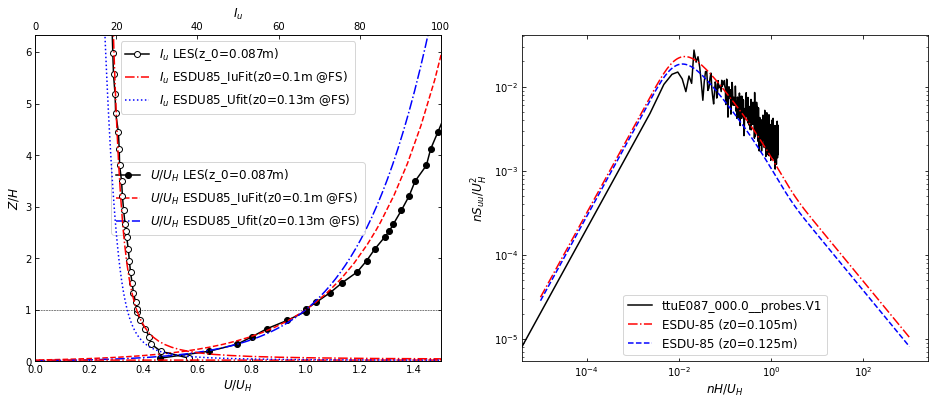

In [27]:
sIdx = 200
eIdx = 9930
nTime = eIdx-sIdx

# 0 deg
pOfTfile = dir_lesE3_00+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT = np.load(pOfTfile)
m,n = np.shape(pOfT)
pOfT = np.reshape(pOfT,(1,m,n))
T_p = np.load(dir_lesE3_00+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT = foam.read_OF_probe(probeName=p0_ProbeName, postProcDir=dir_lesE3_00+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT = np.reshape(np.transpose(p0OfT)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT = p0OfT[:,:,idx_p0]

p0OfT = p0OfT[:,:,:-1]
pOfT = np.subtract(pOfT,p0OfT)[:,:,sIdx:eIdx]



# 45 deg
pOfTfile = dir_lesE3_45+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT_ = np.load(pOfTfile)
m,n = np.shape(pOfT_)
pOfT_ = np.reshape(pOfT_,(1,m,n))
T_p = np.load(dir_lesE3_45+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT_ = foam.read_OF_probe(probeName=p0_ProbeName, postProcDir=dir_lesE3_45+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT_ = np.reshape(np.transpose(p0OfT_)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT_ = p0OfT_[:,:,idx_p0]

pOfT_ = np.subtract(pOfT_,p0OfT_)
pOfT = np.concatenate((pOfT, pOfT_[:,:,sIdx:eIdx]), axis=0)



# 90 deg
pOfTfile = dir_lesE3_90+'postProcessing/wallPressure_pOfT_TNGtaps.npy'
pOfT_ = np.load(pOfTfile)
m,n = np.shape(pOfT_)
pOfT_ = np.reshape(pOfT_,(1,m,n))
T_p = np.load(dir_lesE3_90+'postProcessing/wallPressure_times.npy')

_, T_p0, p0OfT_ = foam.read_OF_probe(probeName=p0_ProbeName, postProcDir=dir_lesE3_90+'postProcessing/', field='p', shiftTimeToZero=False)
p0OfT_ = np.reshape(np.transpose(p0OfT_)[p0Idx,:],(1,1,-1))
idx_p0 = getClosestIdx(T_p, T_p0)
p0OfT_ = p0OfT_[:,:,idx_p0]

pOfT_ = np.subtract(pOfT_,p0OfT_)
pOfT = np.concatenate((pOfT, pOfT_[:,:,sIdx:eIdx]), axis=0)

# lesCp_E3_old = wind.bldgCp(bldgName='TTU_1:50_TNG',
#                 faces=bldg.faces,
#                 H=H,D=D,B=B,roofSlope=1.2,lScl=lScl,
#                 caseName='LES-E3',
#                 refProfile=lesVel_E3_old,
#                 Zref_input=H,  # for the Cp TH being input below
#                 Uref_input=lesVel_E3_old.Uh,  # for the Cp TH being input below
#                 samplingFreq=lesVel_E3_old.samplingFreq,
#                 AoA=AoA,
#                 pOfT=pOfT,
#                 # p0ofT=p0OfT[:,:,100:nT],
#                 peakSpecs=peakSpecs,
#                 badTaps=badTaps,
#                 # keepTH=False,
#                 )

lesCp_E3_old = wind.bldgCp(
                    bldgName=bldg.name,
                    faces=bldg.faces,
                    H=H,D=D,B=B,roofSlope=roofSlope,lScl=lScl,
                    AoA_zero_deg_basisVector=bldg.AoA_zero_deg_basisVector,
                    AoA_rotation_direction=bldg.AoA_rotation_direction,
                    caseName='LES-E2',
                    refProfile=lesVel_E3_old,
                    samplingFreq=lesVel_E3_old.samplingFreq,
                    Uref_input=lesVel_E3_old.Uh,  # for the Cp TH being input below
                    Uref_FS=25.0,
                    AoA=AoA, #caseDict['AoAs'],
                    CpOfT=None,
                    notes_Cp='---',
                    badTaps=None,
                    reReferenceCpToH=False,
                    pOfT=pOfT,
                    # p0ofT=p0_prof.pOfT[:nmin,-10],
                    CpStats=None,
                    peakSpecs=peakSpecs,
                    CpStats_fields=['mean','std','peak','skewness','kurtosis'],
                    keepTH=True,
                    )

lesCp_E3_old.profile.fit_z0(debugMode=True)

pOfT = pOfT_ = None



In [28]:
cps = wind.BldgCps([WT_cp, lesCp_E2_old])
profs = wind.Profiles([WT_cp.profile, lesCp_E2_old.profile])

# cps.plotParamsTable()
# _ = profs.plotProfile_basic2()
# _ = profs.plotSpect()

Number of member bldgs: 2


In [29]:
Tstar_les = np.mean(lesCp_E2_old.T_star)
T_wt = Tstar_les * WT_cp.H/ np.mean(WT_cp.Uref)

print(T_wt)

20.506088699932647


## validator

In [30]:
validator = wind.validator(target=WT_cp, 
                           # model=lesCp_E2_old, 
                        model=LES_Cp,
                        correctForIuDifference=True)


# print(json.dumps(validator.error_CpStats['peakMin'], indent=4))
# print(validator.error_CpStats.keys())


D:\OneDrive - The University of Western Ontario\Documents\PhD\Thesis\CodeRepositories\windCalc\src\wind.py:5149: RuntimeWarning: invalid value encountered in log10
  tmp1['orderOfMagnitude'][key] = np.log10(mp_i/tp_i)


# Plots

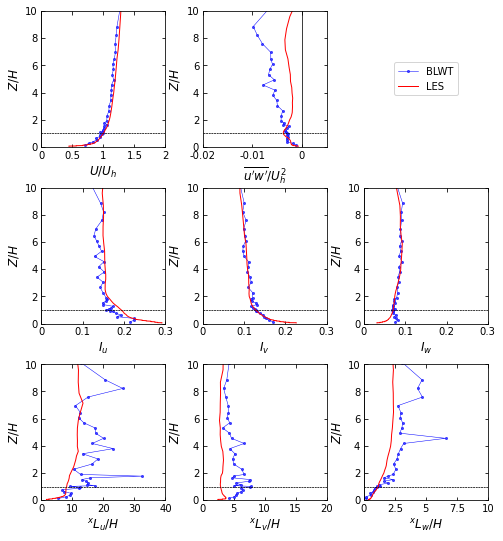

In [31]:
WT_cp.profile.name = 'BLWT'
LES_Cp.profile.name = 'LES'
es74 = esdu74_E2.toProfileObj()
es74.name = 'ESDU-74 ($z_0=0.01m$)'
es85 = esdu85_E2.toProfileObj()
es85.name = 'ESDU-85 ($z_0=0.01m$)'
profs = wind.Profiles([WT_cp.profile, LES_Cp.profile]) #, es74, es85])

fig, axs = profs.plotProfile_basic2(figsize=[8,9], hspace=0.3, wspace=0.3,
            yLimits=[0,10],
            xLimits_U=[0, 2], xLimits_uw=[-0.02, 0.005], 
            xLimits_Iu=[0,0.3], xLimits_Iv=[0,0.3], xLimits_Iw=[0,0.3], 
            xLimits_xLu=[0, 40], xLimits_xLv=[0,20], xLimits_xLw=[0,10], 
            kwargs_plt=[{'color': 'b', 'linewidth':0.5, 'linestyle': '-',       'marker': 's', 'markersize':1.5, 'markerfacecolor':'w'},
                        {'color': 'r', 'linewidth':1.0, 'linestyle': '-',       'marker': 'None', 'markersize':3, 'markerfacecolor':'w'},
                        {'color': 'g', 'linewidth':1.0, 'linestyle': '-',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'b', 'linewidth':1.0, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        {'color': 'k', 'linewidth':1.0, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
                        ],
            lgnd_kwargs={'bbox_to_anchor': (0.5, 0.5), 'loc': 'center', 'ncol': 1},
            kwargs_ax={'gridMajor':False}
            )
# # if saveFigs:
# fig.savefig(figDir+"profile_basic2_simple.svg",format='svg',dpi=1200, bbox_inches='tight')
# print(f"Figure saved to {figDir}profile_basic2.svg")


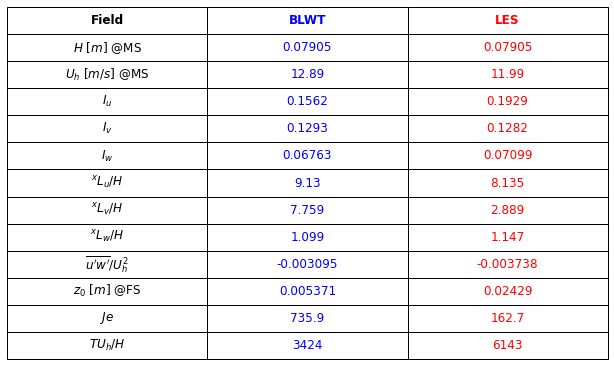

In [32]:
fig, _ = profs.plotParamsTable( figsize_perCell=[2.4,0.36], 
                                # figsize_perCell=[1.5,0.36], 
                                colTxtColors=['b','r'], fontSz=12, 
                                params = 'basic',
                                # params = wind.mathName(['H','Iu','Iv','Iw']),
                                )

# fig.savefig(figDir+"paramsTable.svg",format='svg',dpi=1200, bbox_inches='tight')

Figure saved: D:/tempData_depot/simData_CandC/__forICWE/figs//spectra.svg


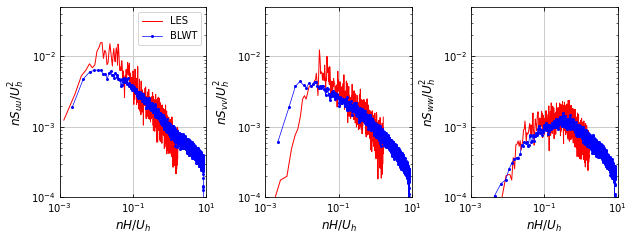

In [33]:
profss = wind.Profiles([LES_Cp.profile, wtVel_E2, ]) #, es74, es85])
LES_Cp.profile.SpectH.name = 'LES'
wtVel_E2.SpectH.name = 'BLWT'

clb = 0
r = [1.0, clb, clb, 1.0]
b = [clb, clb, 1.0, 1.0]
kwargs_plt=[{'color': r, 'markerfacecolor':r, 'markeredgecolor':r, 'alpha':1, 'linewidth':1, 'linestyle': '-',    'marker': '', 'markersize':2},
            {'color': b, 'markerfacecolor':b, 'markeredgecolor':b, 'alpha':1, 'linewidth':0.7, 'linestyle': '-',    'marker': 'o', 'markersize':2},
            {'color': 'r', 'linewidth':2, 'linestyle': '-',       'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            {'color': 'b', 'linewidth':2, 'linestyle': '--',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            {'color': 'k', 'linewidth':2, 'linestyle': '-.',      'marker': 'None', 'markersize':6, 'markerfacecolor':'w'},
            ]

fig, _ = profss.plotSpect(figsize=[10,3.5], xLimits=[1e-3, 1e1], yLimits=[[1e-4,5e-2],[1e-4,5e-2],[1e-4,5e-2]], wspace=0.4,
                    xLabel=r'$nH/U_h$', yLabel_Suu=r'$nS_{uu}/U_h^2$', yLabel_Svv=r'$nS_{vv}/U_h^2$', yLabel_Sww=r'$nS_{ww}/U_h^2$',
                    kwargs_plt=kwargs_plt,)
# if saveFigs:
fig.savefig(figDir+'spectra.svg', format='svg',dpi=600, bbox_inches='tight')
print(f"Figure saved: {figDir}/spectra.svg")

Number of member bldgs: 2


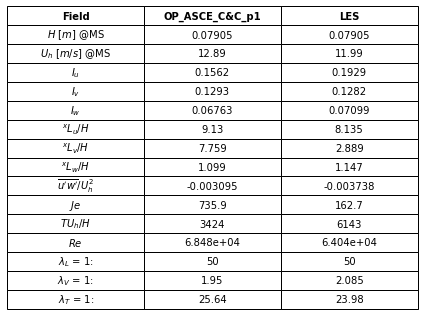

In [34]:
bldgs = wind.BldgCps([WT_cp, LES_Cp])
fig,_ = bldgs.plotParamsTable(params='basic')
# fig.savefig(figDir+"paramsTable_full.svg",format='svg',dpi=1200, bbox_inches='tight')

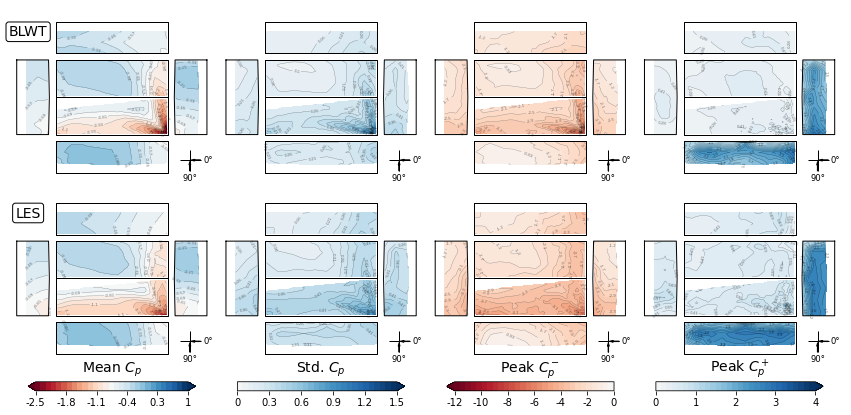

In [35]:
from matplotlib.ticker import FuncFormatter

fig, axs = plt.subplots(3,4,figsize=[15,10])
ax_cbar1 = axs[2,0]
ax_cbar2 = axs[2,1]
ax_cbar3 = axs[2,2]
ax_cbar4 = axs[2,3]

# fig.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
fig.subplots_adjust(wspace=0.0, hspace=0.0)

names = ['BLWT', 'LES']

for i, cp in enumerate([WT_cp, LES_Cp]):

    vals = np.linspace(-2.5, 1.0, 6)
    fld, fldrange, ticks = 'mean', [vals[0], vals[-1]], vals
    
    ax = axs[i,0]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True),)
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.annotate(names[i], xy=(0.1, 0.9), xycoords='axes fraction', fontsize=14, ha='center', va='top',
                bbox=dict(boxstyle="round", fc="w", ec="k", pad=0.2))
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar1.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar1, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar1.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.88, pos.width*0.8, pos.height*0.05]
        ax_cbar1.set_position(new_pos)


    vals = np.linspace(0, 1.5, 6)
    fld, fldrange, ticks = 'std', [vals[0], vals[-1]], vals
    ax = axs[i,1]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                 cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar2.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar2, orientation='horizontal',aspect=20,shrink=0.5,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar2.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.88, pos.width*0.8, pos.height*0.05]
        ax_cbar2.set_position(new_pos)


    vals = np.linspace(-12.0, 0, 7)
    fld, fldrange, ticks = 'peakMin', [vals[0], vals[-1]], vals
    ax = axs[i,2]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='low',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='min',
                                 cmap=wind.sub_cmap(cmap='RdBu', stop=0.5, n=30))
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar3.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar3, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar3.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.88, pos.width*0.8, pos.height*0.05]
        ax_cbar3.set_position(new_pos)


    vals = np.linspace(0, 4.0, 5)
    fld, fldrange, ticks = 'peakMax', [vals[0], vals[-1]], vals
    ax = axs[i,3]
    im = cp.plotTapCpStatContour(ax=ax, envelopeType='high',fieldName=fld,fldRange=fldrange,nLvl=30,title=wind.fullName(fld,abbreviate=True), extend='max',
                                 cmap=wind.sub_cmap(cmap='RdBu', start=0.5, stop=1.0, n=30))
    cp.plotEdges(ax=ax, showName=False)
    cp.plotAoA_definition(ax=ax, size=0.7, marginFactor=[1.0,0.5], location='lower right', AoAs=[0, 90], textOffsetFactor=3.0)
    ax.axis('equal')
    ax.axis('off')
    if i == 1:
        ax_cbar4.axis('on')
        cbar = fig.colorbar(im[0], cax=ax_cbar4, orientation='horizontal',aspect=20,shrink=0.7,pad=0.08)
        cbar.set_ticks(ticks)
        cbar.ax.set_xlabel(wind.fullName(fld,abbreviate=True), fontsize=14, rotation=0, labelpad=10)
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2g}'))
        cbar.ax.xaxis.set_label_position('top')
        pos = ax_cbar4.get_position()
        new_pos = [pos.x0+pos.width*0.1, pos.y0+pos.height*0.88, pos.width*0.8, pos.height*0.05]
        ax_cbar4.set_position(new_pos)

# # if saveFigs:
# fileName = figDir+f"CpContour.svg"
# fig.savefig(fileName,format='svg',dpi=600, bbox_inches='tight')
# print(f"Figure saved to {fileName}")
    

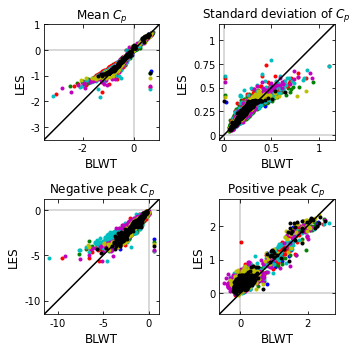

Figure saved: D:/tempData_depot/simData_CandC/__forICWE/figs/CpStatsErrorNew_small.svg


In [66]:

fig, _ = validator.plotError_CpStats(modelLabel='LES', targetLabel='BLWT', percentLinesAt=[], figsize_per_ax=[2.5,2.5],
                                     showErrTxt=False, fields=['mean','std','peakMin','peakMax'], nPltCols=2,
                                    xyLims={'mean':[-3.5, 1], 'skewness': [-5, 3], 'kurtosis': [0, 30]}, cols=wind.def_cols4, showLegend=False,
                                    kwargs_legend={'loc': 'lower left', 'ncol': 2},
                                    )

fig.savefig(figDir+'CpStatsErrorNew_small.svg', bbox_inches='tight', dpi=300)
print(f"Figure saved: {figDir}CpStatsErrorNew_small.svg")

# # _ = validator.plotError_CpStats(xyLims={'skewness': [-5, 3], 'kurtosis': [-0.5, 30]})
# # _ = validator.plotError_CpStats_perAoA()
# # fld, fldRange = 'std', [-0.3, 0.3]
# fld, fldRange = 'mean', [-0.5, 0.8]
# fig, _ = validator.plotError_contour_CpStats(fieldName=fld, nLvl=50, figsize_per_ax=[5,5], AoAs=[0,45], 
#                                              nCols=3, colBarOrientation='vertical', tLbl='BLWT', mLbl='LES',
#                                             showValuesOnContour=False, cmap='seismic',
#                                             fldRange=fldRange)

# # fig.savefig(figDir+'CpStatsError_contour_'+fld+'_new.svg', bbox_inches='tight')


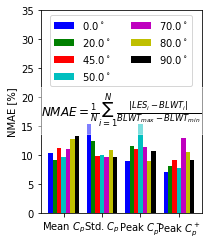

In [72]:
fig, _ = validator.plotError_barChart_CpStats(fields=['mean','std','peakMin','peakMax'], lumpAllAoAs=False, errorType=['NMAE',], kwargs_legend={'loc':'upper center', 'ncol':2},
                                         cols=wind.def_cols4, 
                                        figsize_per_ax=[3.0,3.5], nPltCols=2, yLims={'NMAE':[0, 35], 'NRMSE':[0, 30], },
                                        kwargs_annotation={'xy':(0.5, 0.6), 'xycoords':'axes fraction', 'ha':'center', 'va':'top', 'backgroundcolor':[1,1,1,0.5], 'fontsize':12},
                                   )

fig.savefig(figDir+'CpStatsError_barChart_small.svg', bbox_inches='tight')

### $C_p$ Plots

In [38]:
# cps = wind.BldgCps([WT_cp, LES_Cp_old])

# cols = ['k','r','b','g','m','r','k','b','g','m']
# mrkrs = ['^','o','v','s','p','d','.','*','<','>','h']
# # mrkrs = ['.','.','.','.','.','.','.','','','','']
# ls=['-','-','-','-','-','-','-','-','-','-',]
# kwargs_perFld = [[{ 'color':cols[b], 
#                     'marker':mrkrs[b], 
#                     'ls':ls[f],
#                     'markersize':5,
#                     'linewidth':0.5,
#                     } for f in range(3)]
#                     for b in range(cps.N_bldgs)] 

# _,_ = cps.plotTapCpStatsPerAoA(fields=['std',], #tapsToPlot=bldg.tapNo[:50],
#         fldRange=[-1,2.0], pageNo_xy=(0.5,0.08), nCols=7, nRows=7, figsize=[25,20], xticks=np.arange(0,105,15),
#                                kwargs_perFld=kwargs_perFld)


#### Local pressure

In [39]:
# LES_Cp.plotTapCpStatsPerAoA(fldRange=[-8,2.3],#xticks=np.round(LES_Cp.AoA,0),
#                             pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])
# wtCp_tngE2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(wtCp_tngE2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])

# lesCp_E2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(lesCp_E2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])
# wtCp_tngE2.plotTapCpStatsPerAoA(fldRange=[-8,2.3],xticks=np.round(wtCp_tngE2.AoA,0),pageNo_xy=(0.5,0.06),nCols=13, figsize=[25,20])

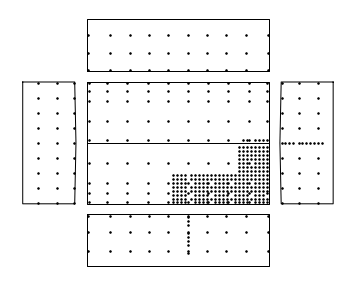

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
bldg.plotTaps(ax=ax)
bldg.plotEdges(ax=ax, showName=False)
ax.set_aspect('equal')
ax.axis('off')
plt.show()

fig.savefig(figDir+'tapLayout.svg', bbox_inches='tight')

#### Area averaged load

Computing C&C Load factor ...
full_scale_duration = 538.5043740200095
z0 = 0.000107m (@MS), 0.00537m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 ASCE
z0		0.00537 		---> 	 0.03	===>	1.21
Z		3.95 		---> 	 10	===>	0.769
gust_dur	538.5 		---> 	 3	===>	0.491
			COMBINED FACTOR			0.4576

C&C factor for case OP_ASCE_C&C_p1 = 0.4576201663215269
Computing C&C Load factor ...
full_scale_duration = 120.72113230910107
z0 = 0.000486m (@MS), 0.0243m (@FS)

Calculating the lumped reference velocity conversion factors for C&C wind loads.
		From 		---> 	 To	===>	Factor
Type		simulated 	---> 	 ASCE
z0		0.0243 		---> 	 0.03	===>	1.03
Z		3.95 		---> 	 10	===>	0.715
gust_dur	120.72 		---> 	 3	===>	0.596
			COMBINED FACTOR			0.439

C&C factor for case LES = 0.4389806582134376


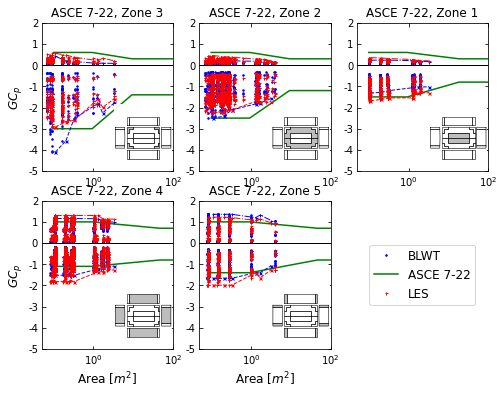

Saved figure: D:/tempData_depot/simData_CandC/__forICWE/figs/CandC_Fig_E_iso.svg


In [63]:
fig = plt.figure(figsize=[8,6])
plt.tight_layout()

NumZones = bldg.NumZones
nCols = min(3, NumZones)
nRows = int(np.ceil(NumZones/nCols))
axs = fig.subplots(nRows, nCols, sharex=False, sharey=False)

for I, zKey in enumerate(bldg.zoneDictKeys):
    i, j = np.unravel_index(I, axs.shape)
    ax = axs[i,j]
    ax.set_title(zKey)
    if i == axs.shape[0]-1:
        ax.set_xlabel(r'Area [$m^2$]')
    if j == 0:
        ax.set_ylabel(r"$GC_p$")
    ax.set_xlim([0.05,100])
    ax.set_ylim([-5,2])

    wind.formatAxis(ax, gridMajor=False, gridMinor=False)

directionalityFactor = 1.0 #0.85
cols = ['b','r','b','g','m','c']
mrkrs = ['.','+','^','v','<','>']
ms = [3,3,3,3,3,3]
names = ['BLWT', 'LES']
for i, cp in enumerate([WT_cp, LES_Cp]):
    if i == 0:
        overlayThese=[
                # windCodes.NBCC2020_CpCg(Figure='4.1.7.6.-C', subfig='a'),
                windCodes.ASCE7_22_GCp(Figure='30.3-2C', subfig='a', outAs='ASCE'),
                ]
        overlayFactors=[
            # 1.0/(directionalityFactor * (windCodes.getDurstFactor(3.0))**2),
            1.0,
            ]
        kwargs_overlay=(
            {'color':'g',}, 
            # {'color':'k', 'linestyle':'--'},
            )
    else:
        overlayThese=None
        overlayFactors=None
        kwargs_overlay=({},)

    _, _ = cp.plotCandC_load(fig=fig, axs=axs, 
                            figSize=[12.5,12], sharex=False, sharey=False,
                            plotExtremesPerNominalArea=False, areaFactor=areaFactor_toFSm2,
                            # xLimits=[0.1,100], yLimits=[-5,1],
                            debugMode=True,
                            CandCLoadFormat='ASCE',
                            yLabel=r"$GC_p$",
                            label_min=names[i], label_max=None,
                            kwargs_min={'color':cols[i], 'marker':mrkrs[i], 'markersize':3,}, # 'linestyle':'-'},
                            kwargs_max={'color':cols[i], 'marker':mrkrs[i], 'markersize':3,}, # 'linestyle':'-'},
                            overlayThese=overlayThese,
                            overlayFactors=overlayFactors,
                            kwargs_overlay=kwargs_overlay,
                            legend_ax_idx=5,
                            kwargs_legend={'loc':'center', 'fontsize':12},
                            # subplotLabels=['(a)','(b)','(c)','(d)','(e)',''], subplotLabels_xy=[0.9,0.94],
                            kwargs_ax={'gridMinor':True},
                            insetBounds=[0.55,0.0,0.445,0.45],
                            zoneShadeColor='darkgray',
                            )

    _, _ = cp.plotCandC_load(fig=fig, axs=axs, 
                            figSize=[12.5,12], sharex=False, sharey=False,
                            plotExtremesPerNominalArea=True, areaFactor=areaFactor_toFSm2,
                            # xLimits=[0.1,100], yLimits=[-5,1],
                            debugMode=False,
                            CandCLoadFormat='ASCE',
                            # yLabel=r"$GC_p$",
                            # label_min=r"BLWT", label_max=None,
                            kwargs_min={'color':cols[i], 'marker':'x', 'markersize':3, 'linestyle':'--', 'lw':1},
                            kwargs_max={'color':cols[i], 'marker':'+', 'markersize':3, 'linestyle':'-.', 'lw':1},
                            plotZoneGeom=False,
                            legend_ax_idx=5, showLegend=False,
                            # kwargs_legend={'loc':'center', 'fontsize':12},
                            # subplotLabels=['(a)','(b)','(c)','(d)','(e)',''], subplotLabels_xy=[0.9,0.94],
                            # kwargs_ax={'gridMinor':True},
                            # insetBounds=[0.4,0.0,0.6,0.4],
                            # zoneShadeColor='k',
                            )
plt.show()

# # if saveFigs:
fig.savefig(figDir+"CandC_small.svg",format='svg',dpi=1200, bbox_inches='tight')
print(f"Saved figure: {figDir}CandC_Fig_E_iso.svg")


# Validate the aerodynamics with line plots (to be implemented)

In [42]:
WT_cp.stat_on_a_line()
validator.plotStats_on_lines()

NotImplementedError: 